In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('cuda_ad_rgb')

In this tutorial, we will optimize the position and rotation of a mesh in order to match a target rendering. To keep things simple, we will use the direct_reparam integrator.

 We will rely on the direct_reparam integrator for this tutorial to properly handle the visibility discontinuities in our differentiable simulation. In primal rendering, this integrator is identical to the direct integrator.

In [2]:
integrator = {
    'type': 'direct_reparam',
}

In [3]:
from mitsuba.scalar_rgb import Transform4f as T

SCENE_DIR = '../scenes/object-pose-estimation/'
scene = mi.load_dict({
    'type': 'scene',
    'integrator': integrator,
    'sensor':  {
        'type': 'perspective',
        'to_world': T.look_at(
                        origin=(0, 0, 2),
                        target=(0, 0, 0),
                        up=(0, 1, 0)
                    ),
        'fov': 45,
        'film': {
            'type': 'hdrfilm',
            'width': 64,
            'height': 64,
            'rfilter': { 'type': 'gaussian' },
            'sample_border': True
        },
    },
    'wall': {
        'type': 'obj',
        'filename': SCENE_DIR + 'meshes/rectangle.obj',
        'to_world': T.translate([0, 0, -2]).scale(2.0),
        'face_normals': True,
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.5, 0.5, 0.5) },
        }
    },
    'bunny': {
        'type': 'ply',
        'filename': SCENE_DIR + 'meshes/bunny.ply',
        'to_world': T.scale(6.5),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.3, 0.3, 0.75) },
        },
    },
    'light': {
        'type': 'obj',
        'filename': SCENE_DIR + 'meshes/sphere.obj',
        'emitter': {
            'type': 'area',
            'radiance': {'type': 'rgb', 'value': [1e3, 1e3, 1e3]}
        },
        'to_world': T.translate([2.5, 2.5, 7.0]).scale(0.25)
    }
})

In [4]:
img_ref = mi.render(scene, seed=0, spp=1024)

mi.util.convert_to_bitmap(img_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 12 KiB of image data ]
]

In [5]:
params = mi.traverse(scene)
initial_vertex_positions = dr.unravel(mi.Point3f, params['bunny.vertex_positions'])

While it would be possible to optimize the vertex positions of the bunny independently, in this example we are only going to optimize a translation and rotation parameter. This drastically constrains the optimization process, which helps with convergence.

In [6]:
opt = mi.ad.Adam(lr=0.025)
opt['angle'] = mi.Float(0.45)
opt['trans'] = mi.Point2f(0.1, -0.25)

From the optimizer’s point of view, those variables are the same as any other variables optimized in the previous tutorials, to the exception that when calling opt.update(), the optimizer doesn’t know how to propagate their new values to the scene parameters. This has to be done manually, and we encapsulate exactly that logic in the function defined below. More detailed explaination on this can be found here.

After clamping the optimized variables to a proper range, this function creates a transformation object combining a translation and rotation and applies it to the vertex positions stored previously. It then flattens those new vertex positions before assigning them to the scene parameters.

In [7]:
def apply_transformations(params, opt):
    opt['trans'] = dr.clamp(opt['trans'], -0.5, 0.5)
    opt['angle'] = dr.clamp(opt['angle'], -0.5, 0.5)

    trafo = mi.Transform4f.translate([opt['trans'].x, opt['trans'].y, 0.0]).rotate([0, 1, 0], opt['angle'] * 100.0)

    params['bunny.vertex_positions'] = dr.ravel(trafo @ initial_vertex_positions)
    params.update()

In [8]:
# initial state
apply_transformations(params, opt)

img_init = mi.render(scene, seed=0, spp=1024)

mi.util.convert_to_bitmap(img_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 12 KiB of image data ]
]

In [9]:
iteration_count = 50
spp = 16

In [10]:
loss_hist = []
for it in range(iteration_count):
    # apply mesh transformation
    apply_transformations(params, opt)

    # perform differentiable rendering
    img = mi.render(scene, params, seed=it, spp=spp)

    # evaluate the objective function, gx, L2
    loss = dr.sum(dr.sqr(img - img_ref)) / len(img)

    # backpropagate through the rendering process
    dr.backward(loss)

    # optimizer: take a GDS
    opt.step()

    loss_hist.append(loss)
    print(f"Iteration {it:02d}: error={loss[0]:6f}, angle={opt['angle'][0]:.4f}, trans=[{opt['trans'].x[0]:.4f}, {opt['trans'].y[0]:.4f}]", end='\r')

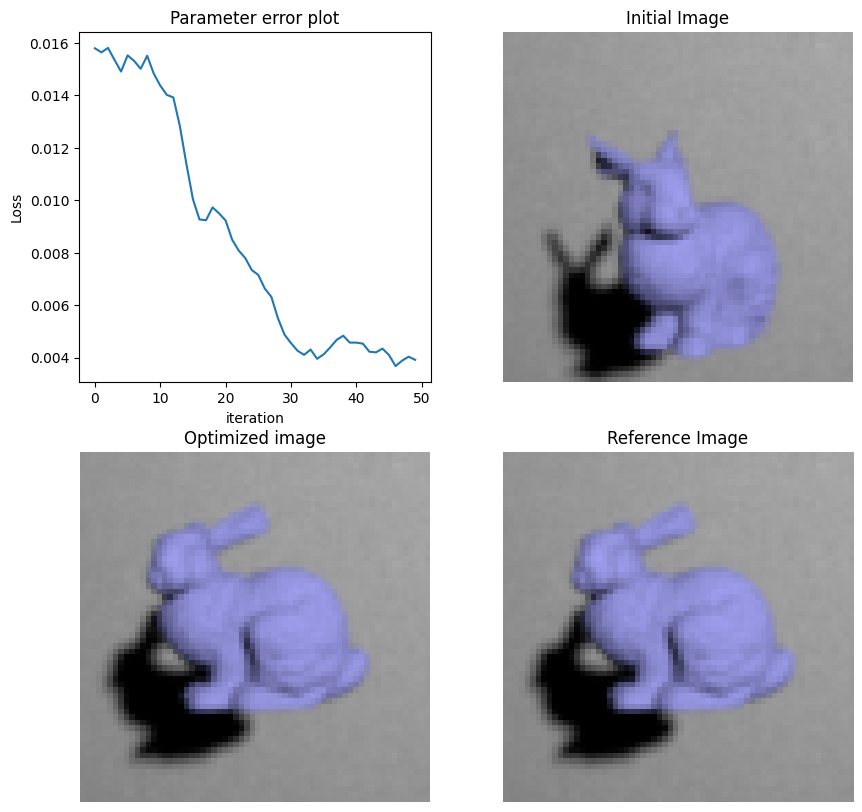

In [11]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title('Parameter error plot');

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=1024)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

axs[1][1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');
fig.savefig('object-pose-estimation.png')

In [12]:
import drjit as dr
import mitsuba as mi
from mitsuba.scalar_rgb import Transform4f as T

def createIntegrator(integratorType):
    return {
        'type': integratorType
    }

mi.set_variant('cuda_ad_rgb')

integrator = createIntegrator('direct_reparam')
scene = mi.load_file('../scenes/editing-a-scene/cbox.xml')

img_ref = mi.render(scene, spp=1024)
mi.util.convert_to_bitmap(img_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

In [13]:
params = mi.traverse(scene)

In [14]:
params

SceneParameters[
  ----------------------------------------------------------------------------------------
  Name                                 Flags    Type            Parent
  ----------------------------------------------------------------------------------------
  sensor.near_clip                              float           PerspectiveCamera
  sensor.far_clip                               float           PerspectiveCamera
  sensor.shutter_open                           float           PerspectiveCamera
  sensor.shutter_open_time                      float           PerspectiveCamera
  sensor.film.size                              ScalarVector2u  HDRFilm
  sensor.film.crop_size                         ScalarVector2u  HDRFilm
  sensor.film.crop_offset                       ScalarPoint2u   HDRFilm
  sensor.x_fov                                  Float           PerspectiveCamera
  sensor.to_world                               Transform4f     PerspectiveCamera
  gray.reflectance.val